In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils, mobilenet
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train_path = r"/content/drive/MyDrive/Dataset/train"
valid_path = r"/content/drive/MyDrive/Dataset/valid"
test_path = r"/content/drive/MyDrive/Dataset/test"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [4]:
model = mobilenet.MobileNet()
model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [5]:
last_layer = model.layers[-1].output
last_layer

<KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'predictions')>

## Add Dense layer to handle the output layer with 10 classes

In [7]:
output_layer = Dense(units=10, activation='softmax')(last_layer)

In [8]:
model = Model(inputs=model.input, outputs=output_layer)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [9]:
for layer in model.layers[:-26]:
    layer.trainable = False

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30)

Epoch 1/30
172/172 [==============================] - 661s 4s/step - loss: 2.1737 - accuracy: 0.6951 - val_loss: 2.1946 - val_accuracy: 0.4100
Epoch 2/30
172/172 [==============================] - 10s 59ms/step - loss: 1.9727 - accuracy: 0.8312 - val_loss: 1.9238 - val_accuracy: 0.7900
Epoch 3/30
172/172 [==============================] - 11s 61ms/step - loss: 1.7950 - accuracy: 0.8382 - val_loss: 1.7503 - val_accuracy: 0.7833
Epoch 4/30
172/172 [==============================] - 9s 52ms/step - loss: 1.6132 - accuracy: 0.8697 - val_loss: 2.0076 - val_accuracy: 0.4233
Epoch 5/30
172/172 [==============================] - 10s 59ms/step - loss: 1.4495 - accuracy: 0.8732 - val_loss: 1.3869 - val_accuracy: 0.8800
Epoch 6/30
172/172 [==============================] - 11s 63ms/step - loss: 1.2942 - accuracy: 0.8849 - val_loss: 1.6423 - val_accuracy: 0.5667
Epoch 7/30
172/172 [==============================] - 9s 52ms/step - loss: 1.1837 - accuracy: 0.8697 - val_loss: 1.1566 - val_accuracy: 0.

## Confusion matrix parameters

In [14]:
test_labels = test_batches.classes
test_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9], dtype=int32)

In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches))

5/5 [==============================] - 16s 4s/step


## Plot confusion matrix

In [16]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 4, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 4]])

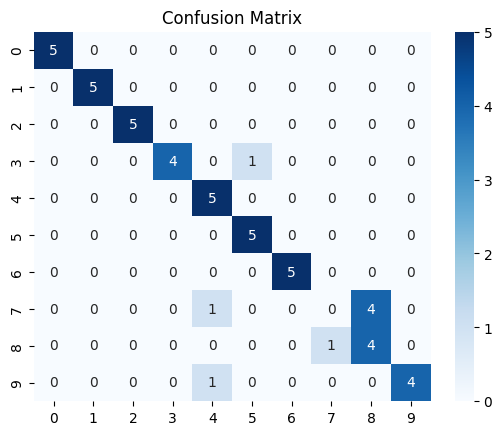

In [17]:
normalized_cm = 50 * cm / np.sum(cm)

disp = sns.heatmap(normalized_cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()